# Ice sheet velocity data from satellite observations: temporal and spatial variability of velocity-related uncertainties for glaciological applications

Production date: 31-05-2025

Dataset version: 1.3 to 1.5

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Using remote sensing-derived ice sheet surface flow velocities for the calibration or validation of a simulation with an ice sheet model

## ❓ Quality assessment question
* **"How does the uncertainty of the horizontal ice sheet surface flow velocity vary in space and time and is the dataset sufficiently accurate and precise to be used in an ice sheet modeling framework?"**

Ice sheets are not static, but instead flow. The total velocity magnitude is the sum of the velocity related to internal ice deformation, and is complemented by basal sliding and bed deformation components. Mapping ice sheet surface flow velocities and their temporal changes provides key information for investigating the dynamic response of the ice sheets to climate change. Remote sensing techniques, such as the use of satellites, are an important feature to derive and study these flow velocities. Satellites are able to inspect directly and repeatedly large areas of ice, and, as such are able to detect the movement of its surface. Remote sensing techniques that use satellite data are therefore considered the only feasible manner to derive accurate surface velocities of the ice sheets on a regular basis. In this dataset, they are derived by applying offset tracking techniques using Sentinel-1 synthetic aperture radar (SAR) satellite data. The main principle of the "[Ice sheet velocity for Antarctica and Greenland derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=overview)" dataset therefore relies on the preservation of surface features or other detectable patterns (e.g. speckle) in between multiple image acquisition periods. The extraction of these features/patterns from images acquired over different time periods is used to detect their displacements, and with further processing this information can be used to derive velocity fields [[1](https://doi.org/10.3390/rs70709371)]. 

This notebook investigates how well the dataset on the CDS (here we use versions 1.3 to 1.5) can be used in the context of an ice sheet modelling framework for Greenland and Antarctica. More specifically, the notebook evaluates whether the dataset is of sufficient maturity and quality for that purpose in terms of its spatio-temporal coverage and uncertainty. 

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note

- Ice velocity (“displacement”) observation by satellites is a useful tool to grasp the overall patterns of flow dynamics of the ice sheets. The C3S ice sheet velocity dataset provides annually averaged surface velocities for both the Greenland (GrIS) and Antarctic (AIS) Ice Sheets at a high spatial resolution that meets international proposed standards. However, the temporal extent of the data series is rather short and significant data gaps remain over the interior of the AIS.
- Data quality in terms of error and uncertainty can be assessed by two variables: the standard deviation (as a precision error estimate) and the valid pixel count maps (as the total number of valid measurements used in the annually averaged velocity estimate over 1 year of data acquisition). Consulting the accompanying standard deviation and the valid measurement count maps is therefore recommended to assess the error and uncertainty characterization of the product. The majority of pixels meet the proposed GCOS thresholds in terms of uncertainty. However, data quality can be slightly lower in some regions (due to 'striping', higher error values and/or lower valid measurements). Errors are furthermore provided as absolute values, while for flow fields, the relative error is generally considered to be more useful.
- Due to the high spatial resolution/coverage and the quality-rich uncertainty characterization, the C3S ice sheet velocity dataset is particularly well-suited for the use as a calibration or validation tool within an ice sheet modelling framework. The user can, if desired, prioritize high-quality data (i.e. pixels with low absolute or relative errors and/or high valid pixel counts) when adjusting tuning parameters in an ice sheet model, such that the modelled ice thickness or surface velocity matches the observed one as close as possible.
```

## 📋 Methodology

### Dataset description

The 'Ice sheet velocity for Antarctica and Greenland derived from satellite observations' dataset, available on the Climate Data Store (CDS), offers annually averaged surface ice flow velocities and their easting and northing components for the Antarctic (AIS) and Greenland (GrIS) Ice Sheets. This data is provided on a spatial resolution grid of either 200 m, 250 m or 500 m, depending on the ice sheet and dataset version. The dataset includes horizontal velocity components in the east and north directions, as well as the total horizontal velocity magnitude and its uncertainty, expressed as 1-sigma precission errors. Surface flow velocities are treated as “displacements”, normalized to true meters per day, and are available for each glaciological year since 2014-2015 for the GrIS and since 2021-2022 for the AIS. The horizontal velocities and their components are derived using offset tracking techniques with Sentinel-1 synthetic aperture radar (SAR) satellite data. The data are provided in NetCDF format as gridded data fields in Polar Stereographic projection, covering the entire GrIS domain, including peripheral glaciers and ice caps. 

### Structure and (sub)sections

**[](section-1)**

* [](section-1-1)
* [](section-1-2)
* [](section-1-3)

**[](section-2)**
* [](section-2-1)
* [](section-2-2)
* [](section-2-3)
* [](section-2-4)

**[](section-3)**
* [](section-3-1)
* [](section-3-2)

**[](section-4)**
* [](section-4-1)
* [](section-4-2)

**[](section-5)**

## 📈 Analysis and results

(section-1)=
### 1. Data preparation and processing

(section-1-1)=
#### 1.1 Import packages

First we load the packages:

In [1]:
import matplotlib.colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
import math
import matplotlib.ticker as ticker
from scipy.stats import circmean
from c3s_eqc_automatic_quality_control import download
import os
plt.style.use("seaborn-v0_8-notebook")
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")

(section-1-2)=
#### 1.2 Define request and download

Then we define requests for download from the CDS and download the GrIS and AIS velocity data and immediately perform some data handling to make the dataset more readable.

🚨 **The files can be large! Since the data files to be downloaded are of considerable size due to the high spatial resolution, this may take a couple of minutes.**

In [2]:
periods = {
    "greenland_ice_sheet": ["2014_2015", "2022_2023"],
    "antarctic_ice_sheet": ["2021_2022", "2022_2023"],
}
assert all([len(value) == 2 for value in periods.values()])

print("Downloading ice sheet velocity data, this make take a couple of minutes...")

def compute_std_flowdirection_and_reform(ds):
    # Add period dim
    start, stop = ds.summary.strip(".").split("from")[-1].split("to")
    period = "-".join([start.strip()[:4], stop.strip()[:4]])
    ds = ds.squeeze("source").expand_dims(period=[period])

    # Compute standard deviation
    std = (
        ds["land_ice_surface_easting_stddev"] ** 2
        + ds["land_ice_surface_northing_stddev"] ** 2
    ) ** 0.5
    std.attrs = {
        "long_name": "Velocity standard deviation",
        "units": ds["land_ice_surface_easting_stddev"].attrs.get("units", "m/year"),
    }
    ds["land_ice_surface_stddev"] = std

    # Flow direction
    angle_radians = np.arctan2(
        ds["land_ice_surface_northing_velocity"],
        ds["land_ice_surface_easting_velocity"],
    )
    angle_degrees = np.degrees(angle_radians)
    flow_direction = (90 - angle_degrees) % 360
    flow_direction.attrs = {
        "long_name": "Flow direction",
        "units": "degrees",
    }
    ds["land_ice_flow_direction"] = flow_direction

    # Keep only selected variables
    keep_vars = [
        "land_ice_surface_velocity_magnitude",
        "land_ice_surface_measurement_count",
        "land_ice_surface_stddev",
        "land_ice_flow_direction",
    ]
    ds = ds[keep_vars]

    for var in ds.data_vars:
        ds[var].encoding["chunksizes"] = tuple(map(max, ds[var].chunks))
    return ds

def postprocess(ds):
    for name, da in ds.data_vars.items():
        if name == "land_ice_surface_measurement_count":
            da.attrs["units"] = "image pairs"
            da.attrs["long_name"] = "Count of valid measurements"
        if name == "land_ice_flow_direction":
            da.attrs["units"] = "degrees"
            da.attrs["long_name"] = "Flow direction"
        if name == "land_ice_surface_velocity_magnitude":
            da.attrs["units"] = "m/year"
            da.attrs["long_name"] = "Velocity magnitude"
        if name == "land_ice_surface_stddev":
            da.attrs["units"] = "m/year"
            da.attrs["long_name"] = "Velocity standard deviation"
        if "long_name" not in da.attrs:
            da.attrs["long_name"] = da.attrs.get("description", name.replace("_", " "))
    return ds

collection_id = "satellite-greenland-ice-sheet-velocity"
request = {
    "variable": "all",
    "format": "zip",
}

datasets = {}
for domain, (period_start, period_stop) in periods.items():
    print(f"{domain = }")
    requests = []
    y0_start, y1_start = map(int, period_start.split("_"))
    y0_stop, y1_stop = map(int, period_stop.split("_"))
    for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1)):
        period = f"{y0}_{y1}"
        if y0 >= 2021:
            version = "1_5"
        elif y0 >= 2020:
            version = "1_4"
        else:
            version = "1_3"
        requests.append(
            request | {"domain": domain} | {"version": version, "period": period}
        )
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=compute_std_flowdirection_and_reform,
    )
    datasets[domain] = postprocess(ds)

print("Downloading ice sheet velocity data complete.")

domain = 'greenland_ice_sheet'


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


domain = 'antarctic_ice_sheet'


100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

(section-1-3)=
#### 1.3 Display and inspect data structure

Let us print out the data to inspect its structure after the data handling:

In [3]:
datasets

{'greenland_ice_sheet': <xarray.Dataset> Size: 12GB
 Dimensions:                              (period: 9, y: 10801, x: 5984)
 Coordinates:
   * period                               (period) <U9 324B '2014-2015' ... '2...
     source                               (period) <U32 1kB '3f623b8825fe15dda...
   * y                                    (y) float64 86kB -6.556e+05 ... -3.3...
   * x                                    (x) float64 48kB -6.399e+05 ... 8.55...
 Data variables:
     land_ice_surface_velocity_magnitude  (period, y, x) float32 2GB dask.array<chunksize=(1, 3601, 1995), meta=np.ndarray>
     land_ice_surface_measurement_count   (period, y, x) float64 5GB dask.array<chunksize=(1, 3601, 1995), meta=np.ndarray>
     land_ice_surface_stddev              (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
     land_ice_flow_direction              (period, y, x) float32 2GB dask.array<chunksize=(1, 1351, 748), meta=np.ndarray>
 Attributes: (12/13)
 

For the GrIS, the versions 1.3 to 1.5 are a gridded dataset at a 250 m spatial resolution containing annually averaged values of the ice sheet horizontal surface flow velocity $V_s$ (in m/day) of a grid cell (`land_ice_surface_velocity_magnitude`) and its components (`land_ice_surface_easting_velocity` ($V_x$) and `land_ice_surface_northing_velocity` ($V_y$)) since the 2014-2015 hydrological year. The uncertainties (reported as precision errors or standard deviations) of the horizontal components are also given as `land_ice_surface_easting_stddev` ($\sigma_{V_x}$) and `land_ice_surface_northing_stddev` ($\sigma_{V_y}$). Also the vertical component is given as `land_ice_surface_vertical_velocity` ($V_z$), but without a corresponding uncertainty. Next to that, also a variable named `land_ice_surface_measurement_count` is present, which quantifies the total number of valid image pairs used in the annually averaged velocity estimate for a certain pixel. For the AIS, only version 1.5 is available at a spatial resolution of 200 m since the 2021-2022 period. After the data handling we performed, our dataset array now only holds the most important information: the total horizontal velocity magnitude (`land_ice_surface_velocity_magnitude`), the valid pixel count (`land_ice_surface_measurement_count`), the calculated ice flow direction (`land_ice_flow_direction`), and our calculated standard deviation (`land_ice_surface_stddev`) from the northing and easting components. 

For clarification, the total horizontal surface velocity magnitude $V_s$ and its uncertainty $\sigma_{V_s}$ are calculated from its components as follows (with subscript 's' referring to the surface):

$
V_s
$
[m day⁻¹] 
$
= \sqrt {V_x^2 + V_y^2}
$

$
\sigma_{V_s}
$
[m day⁻¹] 
$
= \sqrt {(\sigma_{V_x})^2 + (\sigma_{V_y})^2}
$

where $V_x$ and $V_y$ are respectively the easting and northing components of the horizontal velocity vector. 

The flow direction of the ice can be calculated as follows:

$
\theta_{\text{V}_s} = \left( 90^\circ - \left( \arctan2(v_y, v_x) \times \left( \frac{180}{\pi} \right) \right) \right) \mod 360^\circ
$

Let us begin with the analysis.

(section-2)=
### 2. Ice sheet flow velocities and their uncertainty estimates in space and time

(section-2-1)=
#### 2.1 Average horizontal ice flow velocities

We begin by plotting the average ice flow velocities for each hydrological year between the beginning and end period that we selected for the velocity data with a defined plotting function. Let us begin with the GrIS:

🚨 **The files can be large! Since the data files to be plotted are of considerable size, this may take a couple of minutes.**

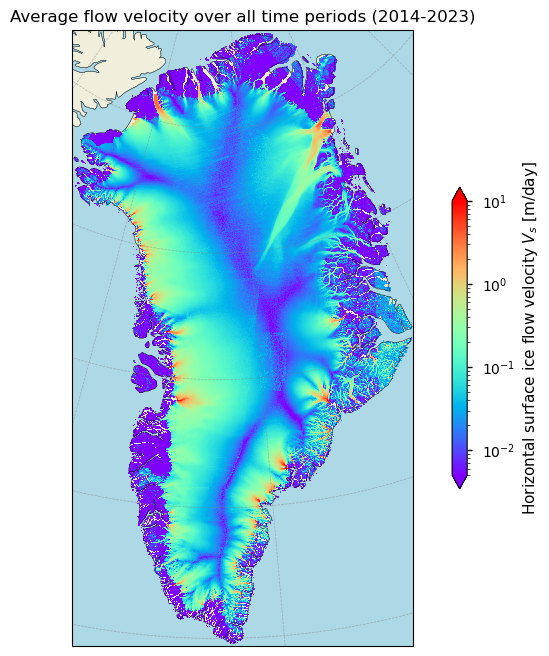

In [5]:
# Greenland setup
ds_gris = datasets["greenland_ice_sheet"]
projection_gris = ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)

# Extract and preprocess data
slice_step = 5
da_gris = ds_gris["land_ice_surface_velocity_magnitude"]
da_gris = da_gris.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
da_gris.attrs = {
    "long_name": r"Horizontal surface ice flow velocity $V_{s}$",
    "units": "m/day",
}
start = da_gris["period"][0].item()[:4]
stop = da_gris["period"][-1].item()[-4:]

# Plot Greenland
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection_gris})
im = da_gris.mean("period", keep_attrs=True).plot.imshow(
    ax=ax,
    norm=matplotlib.colors.LogNorm(),
    vmin=0.005,
    vmax=10,
    cmap="rainbow",  
    add_colorbar=False,  # Disable default colorbar
)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
# Colorbar with formatting 
cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
label = f"{da_gris.attrs.get('long_name', 'Variable')} [{da_gris.attrs.get('units', 'units')}]"
cb.set_label(label)

# Title
ax.set_title(f"Average flow velocity over all time periods ({start}-{stop})")
plt.show()

*Figure 1. Magnitude of the average horizontal surface flow velocities over Greenland over the defined time period.*

And now also the AIS:

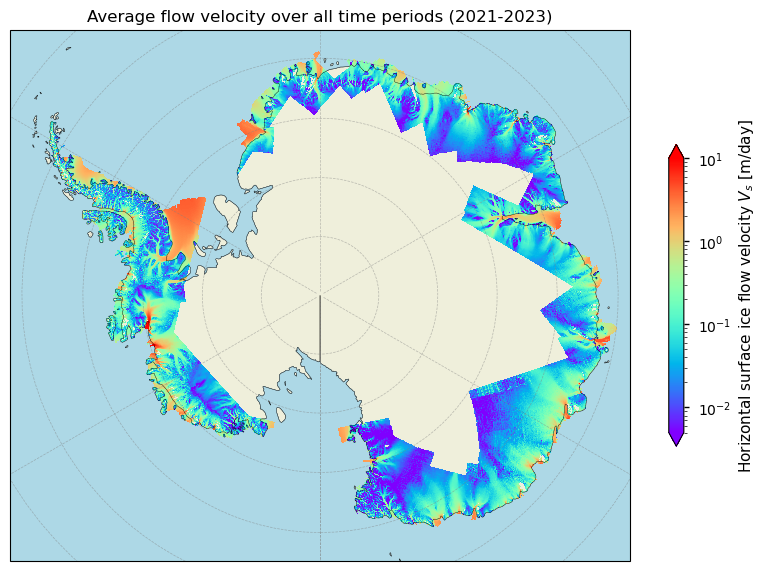

In [7]:
# Antarctica setup
ds_ais = datasets["antarctic_ice_sheet"]
projection_ais = ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71)

# Extract and preprocess data
da_ais = ds_ais["land_ice_surface_velocity_magnitude"]
da_ais = da_ais.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
da_ais.attrs = {
    "long_name": r"Horizontal surface ice flow velocity $V_{s}$",
    "units": "m/day",
}
start = da_ais["period"][0].item()[:4]
stop = da_ais["period"][-1].item()[-4:]

# Plot Antarctica
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection_ais})
im = da_ais.mean("period", keep_attrs=True).plot.imshow(
    ax=ax,
    norm=matplotlib.colors.LogNorm(),
    vmin=0.005,
    vmax=10,
    cmap="rainbow",  
    add_colorbar=False,  # Disable default colorbar
)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
# Colorbar with formatting 
cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
label = f"{da_ais.attrs.get('long_name', 'Variable')} [{da_ais.attrs.get('units', 'units')}]"
cb.set_label(label)

# Title
ax.set_title(f"Average flow velocity over all time periods ({start}-{stop})")
plt.show()

*Figure 2. Magnitude of the average horizontal surface flow velocities over Antarctica over the defined time period.*

The corresponding data are annually averaged values, and are hence derived from all-year round observations during the glaciological balance year. The annually averaged nature of the data meets the minimum requirement for GCOS (Global Climate Observing System) [[2](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. For the GrIS, the dataset shows almost no temporal or spatial (as most have been filled up) data gaps and is presented as gridded values at a spatial resolution of 250 meter (for versions 1.3 to 1.5 as used here), even though spatially filled gaps are not flagged and hence not detectable. The spatial coverage of the data thus approximates 100% and encompasses the entire ice sheet, including peripheral glaciers and ice caps. However, an ice mask is not included and it is thus not possible to exclude non ice-covered pixels from the data. Pixels over ice-free terrain hold non-NaN data and have not been removed, implying that the data exhibits false low velocity measurements and noise over ice-free terrain. For the AIS, most of the margin is covered by the C3S product, but no values are present over the interior of the ice sheet due to the Sentinel-1 acquisition mask (data is only collected at the margins).

(section-2-2)=
#### 2.2 Ice flow velocity uncertainty: accuracy and precision

Let us now consider the unceratinty of the dataset. The total error of an annual ice flow velocity estimate is theoretically given by the sum of the precision (random) and the accuracy (systematic) error:

$
\varepsilon = a\sigma + \delta
$
where $\sigma$ is the random error (i.e. standard deviation), $a$ the critical z-score related to a certain confidence interval, and $\delta$ the systematic error. 

In the ice flow velocity dataset, precision errors are reported as the standard deviation (i.e. the 68% confidence interval) and the accuracy error is not provided. Therefore, in our case, $\delta$ = 0. 

Accuracy errors are thus not directly included in the total error estimate of the dataset. To get an idea of the accuracy, the [PQAR](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355348656) can be consulted, where the results of a validation study are summarized. The validation process involved comparing the velocity maps with in-situ GPS data from various sites, as well as with NASA's MEaSUREs velocity product [[3](https://nsidc.org/data/nsidc-0777/versions/1)]. Quality assurance furthermore included an algorithm performance assessment in stable terrain (where velocities should equal 0) [[6](https://doi.org/10.1016/j.rse.2017.08.038)]. The results demonstrate a relatively good agreement between the dataset and independent external data. 

Quantitative pixel-by-pixel error estimates are, on the other hand, available for the dataset in the form of precision errors and valid measurement counts. The uncertainty characterization is hence quantified by two variables: the standard deviation (i.e. a precision error from a 5x5 pixel neighbourhood) of the velocity estimate with units of m/day, and the valid pixel count (the number of non-NaN observations used in the production of each annual velocity estimate for a certain pixel, or differently stated, the amount of individual displacement estimates (i.e. image pairs) that were used to calculate the annually averaged velocity at that pixel). Let us express the valid pixel count variable with symbol $N_{VP}$.

We will proceed by changing the units of the error $\varepsilon$ to m yr⁻¹ because the GCOS Implementation Plan report advises uncertainty values to be provided in these units [[2](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. We will also multiply the standard deviation by 2 because the GCOS assesses precision errors in the form of 2 standard deviations:

$
\varepsilon_{{V_s}}
$
[m yr⁻¹]
$
= 365.25 \cdot (2 \cdot \sigma_{V_{s}})
$

We can now perform some statistics on the error term over all pixels and all years to inspect its overall value for both ice sheets:

In [17]:
for domain, ds in datasets.items():
    print(f"\n{domain = }")
    # Show error
    da = 2 * 365.25 * ds["land_ice_surface_stddev"].mean(["x", "y"])
    for period, da in da.groupby("period"):
        value = abs(da.compute().item())
        print(f"Mean velocity error (2σ) for {period} CE: {value:.2f} m/yr")

    # Show measurements count
    da = ds["land_ice_surface_measurement_count"].mean(["x", "y"])
    for period, da in da.groupby("period"):
        value = abs(da.compute().item())
        print(f"Mean measurement count for {period} CE: {value:.2f} estimates/pixel")


domain = 'greenland_ice_sheet'
Mean velocity error (2σ) for 2014-2015 CE: 20.42 m/yr
Mean velocity error (2σ) for 2015-2016 CE: 10.93 m/yr
Mean velocity error (2σ) for 2016-2017 CE: 9.92 m/yr
Mean velocity error (2σ) for 2017-2018 CE: 9.19 m/yr
Mean velocity error (2σ) for 2018-2019 CE: 7.90 m/yr
Mean velocity error (2σ) for 2019-2020 CE: 7.14 m/yr
Mean velocity error (2σ) for 2020-2021 CE: 328.67 m/yr
Mean velocity error (2σ) for 2021-2022 CE: 7.69 m/yr
Mean velocity error (2σ) for 2022-2023 CE: 12.84 m/yr
Mean measurement count for 2014-2015 CE: 19.75 estimates/pixel
Mean measurement count for 2015-2016 CE: 61.04 estimates/pixel
Mean measurement count for 2016-2017 CE: 108.80 estimates/pixel
Mean measurement count for 2017-2018 CE: 133.65 estimates/pixel
Mean measurement count for 2018-2019 CE: 138.09 estimates/pixel
Mean measurement count for 2019-2020 CE: 136.80 estimates/pixel
Mean measurement count for 2020-2021 CE: 122.56 estimates/pixel
Mean measurement count for 2021-2022 CE:

The threshold (i.e. the minimum requirement to be met to ensure that data are useful) for surface ice flow velocity uncertainty (expressed in terms of 2$\sigma$) proposed by the GCOS is 100 m yr⁻¹, while the "goal" value (i.e. an ideal requirement above which further improvements are not necessary) would be 10 m yr⁻¹ per grid point [[2](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)]. The overall arithmetic mean error over both space and time shows that the minimum threshold is reached for all years but the 2020-2021 period for the GrIS (which will be discussed later). 

(section-2-3)=
#### 2.3 Spatio-temporal distribution of ice flow velocity uncertainty for the GrIS

Let us now plot the spatial distribution of the errors (here thus visualized as 2 times the standard deviation with units in meters per year):

🚨 **The files can be large! Since the data files to be plotted are of considerable size, this may therefore take a couple of minutes.**

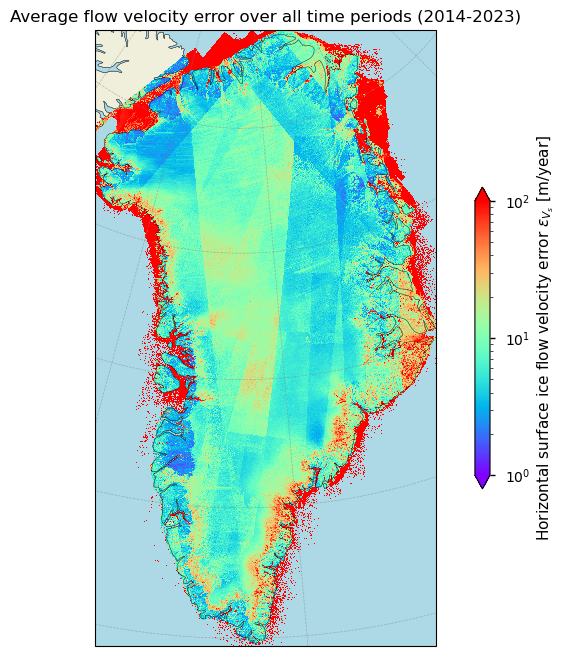

In [8]:
# Greenland setup
ds_gris = datasets["greenland_ice_sheet"]
projection_gris = ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)

# Extract and preprocess data
slice_step = 5
da_gris = 2 * 365.25 * ds_gris["land_ice_surface_stddev"]
da_gris = da_gris.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
da_gris.attrs = {
    "long_name": r"Horizontal surface ice flow velocity error $\varepsilon_{{V_s}}$",
    "units": "m/year",
}
start = da_gris["period"][0].item()[:4]
stop = da_gris["period"][-1].item()[-4:]

# Plot Greenland
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection_gris})
im = da_gris.mean("period", keep_attrs=True).plot.imshow(
    ax=ax,
    norm=matplotlib.colors.LogNorm(),
    vmin=1,
    vmax=100,
    cmap="rainbow",  
    add_colorbar=False,  # Disable default colorbar
)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
# Colorbar with formatting 
cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
label = f"{da_gris.attrs.get('long_name', 'Variable')} [{da_gris.attrs.get('units', 'units')}]"
cb.set_label(label)

# Title
ax.set_title(f"Average flow velocity error over all time periods ({start}-{stop})")
plt.show()

*Figure 3. Magnitude of the average horizontal surface flow velocity error over Greenland over the defined time period.*

Here, high standard deviation areas suggest lower precision and higher uncertainty. From the images above, it can immediately be seen why the horizontal velocity error for the 2020-2021 period is relatively high when compared to the earlier years: the data for this particular  year have not been masked. High errors prevail over the ocean, which is of course unrealistic, and data even extend further into the Canadian Arctic. We can solve this by masking the data (i.e. by excluding the data outside of the Greenland continent land borders) and recalculating the error:

In [9]:
std_2020_2021 = (2 * 365.25 * ds_gris["land_ice_surface_stddev"]).sel(period='2020-2021')
std_2020_2021 = std_2020_2021.where(~np.isnan(ds_gris["land_ice_surface_velocity_magnitude"].sel(period='2020-2021')))
print(f"The masked arithmetic mean precision error (2σ) " 
          f"for the 2020-2021 period "
          f"is {float(np.abs(np.nanmean(std_2020_2021))):.2f} m yr⁻¹.")

The masked arithmetic mean precision error (2σ) for the 2020-2021 period is 6.51 m yr⁻¹.


Nevertheless, from the figure above, the precision errors seem to be especially higher near the margins of the ice sheet. In these regions, the threshold value of 100 m yr⁻¹ is locally not reached. Let us make this plot a bit clearer by grouping the errors (here averaged over all time periods) with respect to the threshold values proposed by the GCOS:

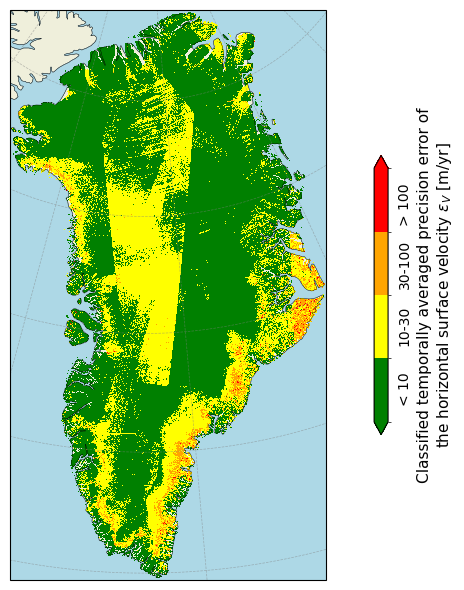

In [10]:
error_m_yr = (2 * 365.25 * ds_gris["land_ice_surface_stddev"]).where(~np.isnan(ds_gris["land_ice_surface_velocity_magnitude"].sel(period='2020-2021')))
slice_step = 5
error_m_yr = error_m_yr.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
error_m_yr = error_m_yr.mean(dim='period')

def plot_maps_single(da, suptitle=None, **kwargs):
    # Create subplots with Polar Stereographic projection
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)})
    if suptitle:
        fig.suptitle(suptitle,fontsize=15)
    
    # Plot the data 
    subset_da = da
    im = subset_da.plot.imshow(ax=ax, add_colorbar=False, **kwargs)
    
    # Set extent and plot features
    ax.set_extent([da.coords['x'].values.min(), da.coords['x'].values.max(), da.coords['y'].values.min(), da.coords['y'].values.max()], ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70))
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.coastlines()
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Add colorbar
    cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49, label="Classified temporally averaged precision error of\nthe horizontal surface velocity $\\epsilon_{V_s}$ [m/yr]")
    cb.set_ticks([(0 + 14) / 2, (10 + 40) / 2, (30+140)/2, (np.nanmax(da))/1.5])  # Set the ticks at the midpoints of the ranges
    cb.set_ticklabels(['< 10', '10-30', '30-100', '> 100'])  # Set the tick labels
    cb.ax.yaxis.set_tick_params(rotation=90)
    cb.ax.yaxis.set_tick_params(length=0)

    plt.tight_layout()
    plt.show()

# Apply the function to the velocity standard deviation data
da = error_m_yr
da.attrs = {
    "long_name": r"Horizontal ice flow velocity error $\varepsilon_{{V_s}}$",
    "units": "m/yr",
}

# Define bounds and colormap
bounds = [0, 10, 30, 100, np.nanmax(da)]
cmap = matplotlib.colors.ListedColormap(['green', 'yellow', 'orange','red'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

_ = plot_maps_single(
    da,
    cmap=cmap,
    norm=norm,
)

*Figure 4. Classification of the average horizontal surface flow velocity error over Greenland over the defined time period according to proposed GCOS thresholds.*

When plotted, the error (in the figure above plotted as averaged over all time periods) of the ice velocity product exhibits a significant spatial variability, with higher values generally observed near the ice sheet margins. Here, the terrain complexity, rapidly changing surface conditions (such as high ice melt or any other changes in the terrain that can alter the scattering characteristics of the radar pulse), as well as the relatively high speed of the outlet glaciers, have a direct impact on the absolute error value [[6](https://www.sciencedirect.com/science/article/pii/S0034425717304121?via%3Dihub)]. Conversely, towards the interior of the ice sheet, where there is little or no melt and ice flow speeds are relatively low and stable, the standard deviation is relatively low as well. 

We can check in what percentage of the pixels the GCOS requirements have been reached or not reached:

In [11]:
error_spatial = (2 * 365.25 * ds_gris["land_ice_surface_stddev"])
count_10 = (error_spatial < 10).sum().values
count_100 = (error_spatial > 100).sum().values
count_nonnan = np.sum(~np.isnan(error_spatial).values)
print(f"The percentage of data points with a velocity precision error value (2σ) less than 10 m yr⁻¹ is {(100*count_10/count_nonnan):.2f}%.")
print(f"The percentage of data points with a velocity precision error value (2σ) more than 100 m yr⁻¹ is {(100*count_100/count_nonnan):.2f}%.")

The percentage of data points with a velocity precision error value (2σ) less than 10 m yr⁻¹ is 71.03%.
The percentage of data points with a velocity precision error value (2σ) more than 100 m yr⁻¹ is 1.54%.


The majority of data therefore meet the uncertainty threshold proposed by the GCOS in the case of the GrIS, which adds credibility to the C3S ice sheet velocity product.

(section-2-4)=
#### 2.4 Spatio-temporal distribution of ice flow velocity uncertainty for the AIS

Now let us repeat the same procedure for Antarctica. We first plot the average velocity errors:

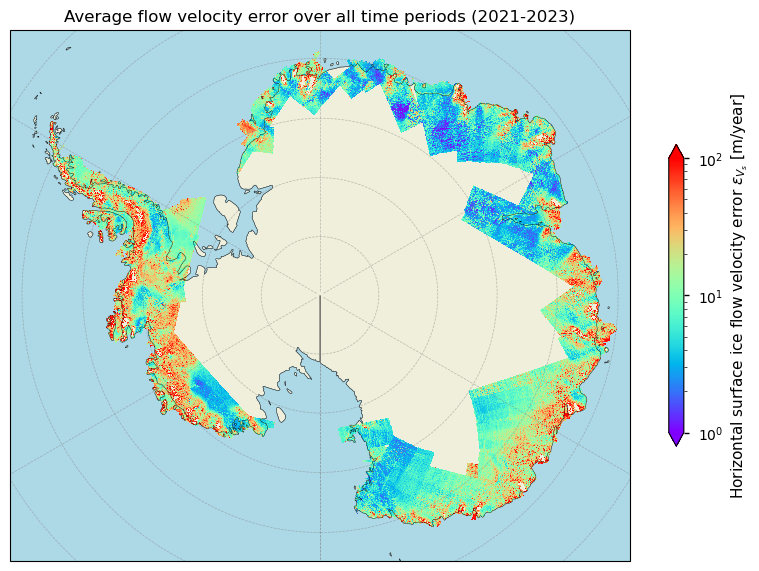

In [12]:
# Antarctica setup
ds_ais = datasets["antarctic_ice_sheet"]
projection_ais = ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71)

# Extract and preprocess data
slice_step = 5
da_ais = 2 * 365.25 * ds_ais["land_ice_surface_stddev"]
da_ais = da_ais.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
da_ais.attrs = {
    "long_name": r"Horizontal surface ice flow velocity error $\varepsilon_{{V_s}}$",
    "units": "m/year",
}
start = da_ais["period"][0].item()[:4]
stop = da_ais["period"][-1].item()[-4:]

# Plot Antarctica
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection_ais})
im = da_ais.mean("period", keep_attrs=True).plot.imshow(
    ax=ax,
    norm=matplotlib.colors.LogNorm(),
    vmin=1,
    vmax=100,
    cmap="rainbow",  
    add_colorbar=False,  # Disable default colorbar
)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
# Colorbar with formatting 
cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
label = f"{da_ais.attrs.get('long_name', 'Variable')} [{da_ais.attrs.get('units', 'units')}]"
cb.set_label(label)

# Title
ax.set_title(f"Average flow velocity error over all time periods ({start}-{stop})")
plt.show()

*Figure 5. Magnitude of the average horizontal surface flow velocity error over Antarctica over the defined time period.*

In the above figure, we note a very similar pattern as with the GrIS: the flow velocity errors are relatively high near the margins, but are considered small over the interior low-flow zones of the ice sheet. Let us classify them according to the proposed GCOS thresholds:

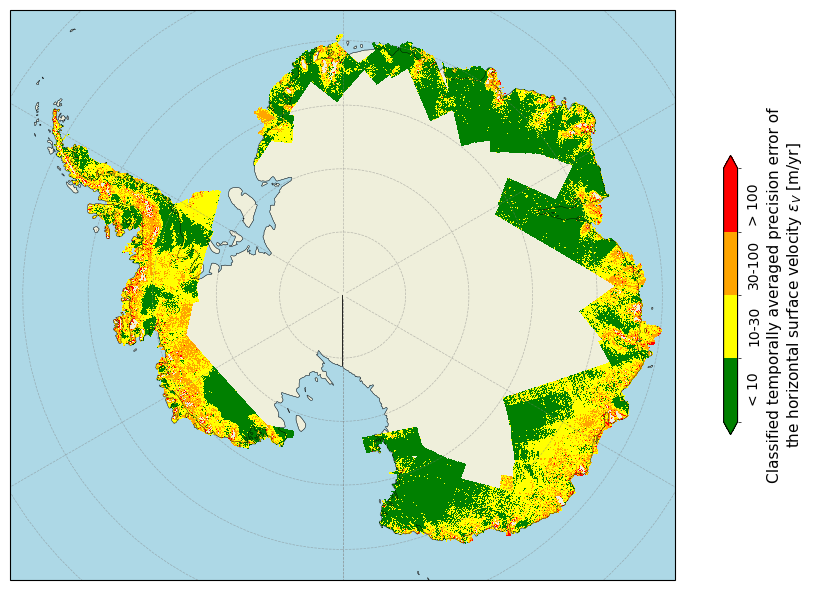

In [16]:
error_m_yr = (2 * 365.25 * ds_ais["land_ice_surface_stddev"])
slice_step = 5
error_m_yr = error_m_yr.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
error_m_yr = error_m_yr.mean(dim='period')

def plot_maps_single(da, suptitle=None, **kwargs):
    # Create subplots with Polar Stereographic projection
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71)})
    if suptitle:
        fig.suptitle(suptitle,fontsize=15)
    
    # Plot the data 
    subset_da = da
    im = subset_da.plot.imshow(ax=ax, add_colorbar=False, **kwargs)
    
    # Set extent and plot features
    ax.set_extent([da.coords['x'].values.min(), da.coords['x'].values.max(), da.coords['y'].values.min(), da.coords['y'].values.max()], ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71))
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.coastlines()
    ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    
    # Add colorbar
    cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49, label="Classified temporally averaged precision error of\nthe horizontal surface velocity $\\epsilon_{V_s}$ [m/yr]")
    cb.set_ticks([(0 + 14) / 2, (10 + 40) / 2, (30+140)/2, (np.nanmax(da))/1.5])  # Set the ticks at the midpoints of the ranges
    cb.set_ticklabels(['< 10', '10-30', '30-100', '> 100'])  # Set the tick labels
    cb.ax.yaxis.set_tick_params(rotation=90)
    cb.ax.yaxis.set_tick_params(length=0)

    plt.tight_layout()
    plt.show()

# Apply the function to the velocity standard deviation data
da = error_m_yr
da.attrs = {
    "long_name": r"Horizontal ice flow velocity error $\varepsilon_{{V_s}}$",
    "units": "m/yr",
}

# Define bounds and colormap
bounds = [0, 10, 30, 100, np.nanmax(da)]
cmap = matplotlib.colors.ListedColormap(['green', 'yellow', 'orange','red'])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

_ = plot_maps_single(
    da,
    cmap=cmap,
    norm=norm,
)

*Figure 6. Classification of the average horizontal surface flow velocity error over Antarctica over the defined time period according to proposed GCOS thresholds.*

The spatio-temporal pattern of ice sheet velocity errors is therefore similar to that of the GrIS. Let us check in what percentage of the pixels the GCOS requirements have been reached or not reached:

In [15]:
error_spatial = (2 * 365.25 * ds_ais["land_ice_surface_stddev"])
count_10 = (error_spatial < 10).sum().values
count_100 = (error_spatial > 100).sum().values
count_nonnan = np.sum(~np.isnan(error_spatial).values)
print(f"The percentage of data points with a velocity precision error value (2σ) less than 10 m yr⁻¹ is {(100*count_10/count_nonnan):.2f}%.")
print(f"The percentage of data points with a velocity precision error value (2σ) more than 100 m yr⁻¹ is {(100*count_100/count_nonnan):.2f}%.")

The percentage of data points with a velocity precision error value (2σ) less than 10 m yr⁻¹ is 55.56%.
The percentage of data points with a velocity precision error value (2σ) more than 100 m yr⁻¹ is 1.59%.


As with the GrIS, the majority of the pixels exhibit uncertainty values that fall within the thresholds proposed by GCOS. This ensures that the C3S AIS velocity product holds credible data. Next, let us deal with the second measure of error and uncertainty: the valid pixel count.

(section-3)=
### 3. Valid measurement counts for the surface ice flow velocity

(section-3-1)=
#### 3.1 Spatio-temporal distribution of ice flow velocity valid pixel counts for the GrIS

In the figure below, we plot the averaged pixel-by-pixel valid measurement counts of the horizontal surface velocity for the GrIS:

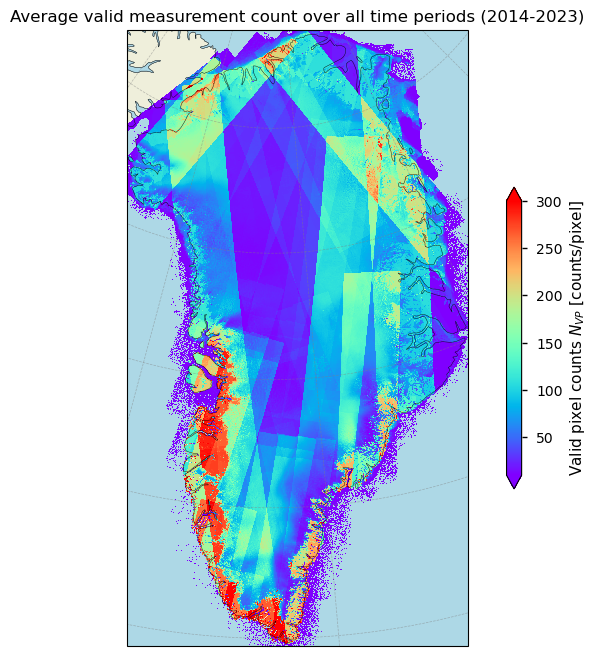

In [18]:
# Greenland setup
ds_gris = datasets["greenland_ice_sheet"]
projection_gris = ccrs.Stereographic(central_longitude=-45, central_latitude=90, true_scale_latitude=70)

# Extract and preprocess data
slice_step = 5
da_gris = ds_gris["land_ice_surface_measurement_count"]
da_gris = da_gris.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
da_gris.attrs = {
    "long_name": r"Valid pixel counts $N_{VP}$",
    "units": "counts/pixel",
}
start = da_gris["period"][0].item()[:4]
stop = da_gris["period"][-1].item()[-4:]

# Plot Greenland
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection_gris})
im = da_gris.mean("period", keep_attrs=True).plot.imshow(
    ax=ax,
    vmin=10,
    vmax=300,
    cmap="rainbow",  
    add_colorbar=False,  # Disable default colorbar
)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
# Colorbar with formatting 
cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
label = f"{da_gris.attrs.get('long_name', 'Variable')} [{da_gris.attrs.get('units', 'units')}]"
cb.set_label(label)

# Title
ax.set_title(f"Average valid measurement count over all time periods ({start}-{stop})")
plt.show()

*Figure 7. Average valid pixel count of the horizontal surface flow velocity for Greenland over the defined time period.*

In the figure above, the straight edges of different valid pixel counts and the apperant paths of data acquisition are an indicator that the differences in valid pixel count are mostly due to the satellite acquisition. However, higher valid pixel counts are clearly observed along the margins of the ice sheet and major outlet glaciers, consistent with areas of fast dynamics that require a more detailed monitoring. This high density of observations enhances the accuracy and reliability of the velocity maps, particularly in dynamic regions. Generating high-density velocity estimates using SAR-based offset tracking is generally more challenging in the interior of the ice sheet. This difficulty mainly arises because of the relatively slow movement of ice in the interior compared to the faster-flowing edges, which results in smaller displacements between image pairs. This makes it harder to detect and measure them accurately. A drawback to the data is the fact that there is no information given related to the time of the year during which valid measurements were acquired and that no data at a finer temporal resolution than 1 year are present. 

(section-3-2)=
#### 3.2 Spatio-temporal distribution of ice flow velocity valid pixel counts for the AIS

Let us plot the same for the AIS:

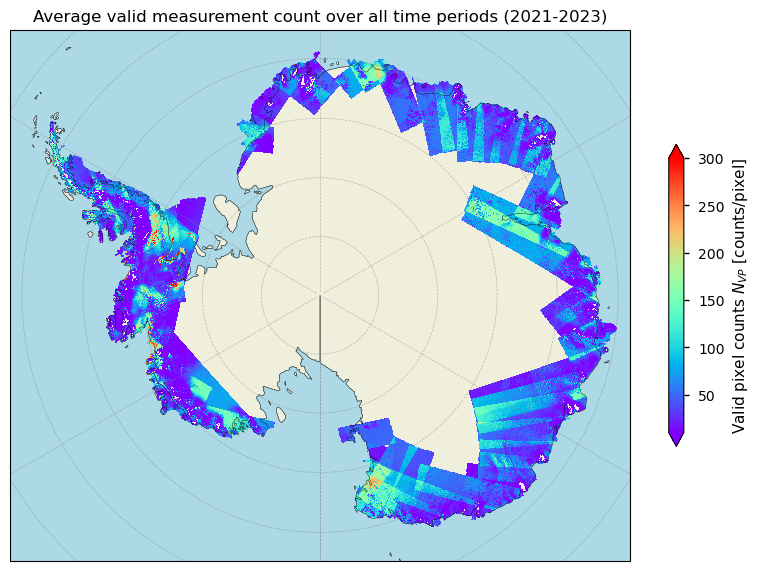

In [25]:
# Antarctica setup
ds_ais = datasets["antarctic_ice_sheet"]
projection_ais = ccrs.Stereographic(central_longitude=0, central_latitude=-90, true_scale_latitude=-71)

# Extract and preprocess data
slice_step = 5
da_ais = ds_ais["land_ice_surface_measurement_count"]
da_ais = da_ais.isel(x=slice(None, None, slice_step), y=slice(None, None, slice_step))
da_ais.attrs = {
    "long_name": r"Valid pixel counts $N_{VP}$",
    "units": "counts/pixel",
}
start = da_ais["period"][0].item()[:4]
stop = da_ais["period"][-1].item()[-4:]

# Plot Antarctica
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": projection_ais})
im = da_ais.mean("period", keep_attrs=True).plot.imshow(
    ax=ax,
    vmin=10,
    vmax=300,
    cmap="rainbow",  
    add_colorbar=False,  # Disable default colorbar
)
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN, color="lightblue")
ax.coastlines()
ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
# Colorbar with formatting 
cb = fig.colorbar(im, ax=ax, extend='both', shrink=0.49)
label = f"{da_ais.attrs.get('long_name', 'Variable')} [{da_ais.attrs.get('units', 'units')}]"
cb.set_label(label)

# Title
ax.set_title(f"Average valid measurement count over all time periods ({start}-{stop})")
plt.show()

*Figure 8. Average valid pixel count of the horizontal surface flow velocity for Antarctica over the defined time period.*

As with the GrIS, a higher count in the figure above typically indicates a more reliable estimate due to the inclusion of more observations into the velocity estimate. Paths of data acquisition are, however, also clearly visible in the pattern. This suggests that valid pixel counts are also dependent on the satellite acquisition and do not always represent glaciological signals. As with Greenland, a drawback to the data is the fact that there is no information given related to the time of the year during which valid measurements were acquired. Again, no thresholds are proposed by GCOS with respect to valid pixel counts, so no comparison is possible. However, the higher the valid pixel count, the more reliable a velocity estimate can be considered.

(section-4)=
### 4. Implications for use of horizontal ice flow velocity data in an ice sheet modelling framework

(section-4-1)=
#### 4.1 Ice sheet model initialisation and tuning of the surface flow velocity field

In the following section, we integrate all information derived above (with respect to spatio-temporal coverage and uncertainty) to assess the suitability of the ice sheet surface ice flow velocity dataset to use the velocity product in an ice sheet modelling framework.

At the heart of an ice sheet model is the solution of the time-dependent continuity equation for ice thickness $H$:

$
\dfrac{\partial H}{\partial t} = -\nabla \cdot (\vec{\overline{v}}H) + M - S
$

where $H$ is the ice thickness, $\vec{\overline{v}}$ is the vertically averaged horizontal velocity vector, $M$ is the surface mass balance, and $S$ is the basal mass balance. A calibration procedure involves adjusting, for example, the basal sliding coefficient in Weertman’s basal sliding law in areas with basal temperatures at the pressure melting point and/or to adjust the rate factor in Glen’s flow law for interior regions frozen to bedrock (which impact $\vec{\overline{v}}$). This allows the modelled ice thickness or surface velocity to match the observed one (e.g. [[4](https://doi.org/10.5194/gmd-12-2481-2019), [5](https://doi.org/10.3390/rs11121407)]). This approach is valid as the present-day velocities of the ice sheets are supposedly close to the balance velocities.

In that regard, comparing modelled surface velocity fields to the observed ones provides a tool for the calibration/validation of an ice sheet model. The C3S ice sheet velocity product is particularly well-suited for this purpose. Even though large spatial gaps remain for the AIS product, the most prominent and dynamic regions across the margins are covered. Moreover, the GrIS product practically entirely covers the Greenland continent. Furthermore, the C3S velocity product includes quantitative pixel-by-pixel error estimates, for which the uncertainty characterization is represented by two variables: the standard deviation (i.e. a precision error) and the valid pixel count (the number of observations used to estimate the eventual average pixel value). The inclusion of both variables enhances the product quality and can serve as an important factor to consider when using the velocity product in an ice sheet modelling framework. When tuning an ice sheet model, it can, for example, be beneficial to prioritize high-quality velocity data (i.e. with a low absolute or relative error and a high valid measurement count). This ensures that the model solution is based on the most reliable observations and higher quality data have a greater influence on the eventual solution. One strategy could be to weigh the data using weights based on both the velocity standard deviation and the valid measurement count. This approach involves combining the two variables to form a single weight $w_i$ for each data point $i$:

$w_i = \alpha \cdot (1-\varepsilon_{V_{s},i}^{'}) + \beta \cdot N_{VP,i}^{'}
$

where:
- $\varepsilon_{V_{s},i}^{'}$ are the normalized (relative) errors, 
- $N_{VP,i}^{'}$ are the normalized valid measurement counts, 
- weights $\alpha$ and $\beta$ for which $\alpha + \beta = 1$.

When using these weights in model validation, each data point's contribution to the model can be weighed accordingly. For instance, the weighted sum of squared residuals can be compared:

$
\sum_i w_i (y_i - f(x_i))^2
$

where:
- $y_i$ is the observed data (i.e. here the velocities from the dataset)
- $f(x_i)$ is the model prediction for the i$^{th}$ data point
- $w_i$ is the weight for the i$^{th}$ data point

(section-4-2)=
#### 4.2 Presence of arteficial 'striping'

Apart from quantitive error estimates, another phenomenom deserves special attention. Namely, the presence of 'striping' (i.e. arteficial banding or noise in the velocity data that become especially visible in low-flow zones) in SAR offset tracking-based ice velocity estimates can have several significant impacts when using the C3S product for the validation of ice sheet models, especially in interior low-flow zones. The presence of striping reduces the overall quality of the velocity data, can distort flow patterns, and may lead to the misinterpretation of physical processes driving ice flow in low-flow zones. This unrealistic pattern, especially visible in the interior of the ice sheet, may therefore limit the use of the product for slowly moving ice and is hence important to consider when using the data. Mitigating these artefacts involves, for example, noise reduction methods such as spatial averaging or filtering, or the integration of velocities from SAR interferomerty, which are generally very accurate for slow-moving ice [[1](https://doi.org/10.3390/rs70709371), [7](https://doi.org/10.3390/rs9101062), [9](https://doi.org/10.1029/2019GL083826)]. Another possible solution is replacing the distorted velocities in these areas by balance velocities or to only use velocities above a certain threshold (i.e. >5 m yr⁻¹) for the relevant procedure.

(section-5)=
### 5. Short summary and take-home messages

Satellite-derived ice velocity data provide valuable insight into the flow dynamics of the ice sheets, but users should be aware of specific limitations in the SAR offset tracking-based velocity products. It should be noted that data quality varies across the ice sheet and is best assessed using the provided standard deviation maps (indicating precision errors) and valid measurement count maps (reflecting the number of successful matches used in annual velocity averaging). Challenging regions include the fast-flowing margins, where high absolute errors occur, as well as the interior low-velocity zones, where lower valid pixel counts and artefacts such as striping may furthermore occur. Nevertheless, the majority of pixels of the C3S ice sheet velocity dataset meets the GCOS uncertainty target. The product also meets the spatial (250 m) and temporal (annual) resolution thresholds set by GCOS, which further enhances the credibility of the C3S ice sheet velocity product (cfr. the "Maturity Matrix" [[8](https://doi.org/10.1175/BAMS-D-21-0109.1)]). However, significant data gaps remain over the interior of the AIS.

The dataset thus offers offers a strong spatial and temporal coverage and uncertainty pattern for use in ice sheet model calibration or validation (e.g. [[4](https://doi.org/10.5194/gmd-12-2481-2019), [5](https://doi.org/10.3390/rs11121407), [10](https://doi.org/10.5194/tc-6-1561-2012)]). The user can, if desired, prioritize high-quality data (i.e. pixels with low absolute/relative errors and high valid pixel counts) for this purpose. Errors are, however, provided as absolute values, while for flow fields, the relative error is generally considered to be more useful. Other potential limitations include the absence of information on acquisition timing, no flagging of spatially filled pixels or missing data, the lack of an ice mask to exclude non-ice-covered cells with velocity values, and the relatively short temporal span of the dataset. To address these issues, users can, for example, apply custom ice masks and complement the product with external datasets for a more robust velocity estimation. 

## ℹ️ If you want to know more

### Key resources

- "[Ice sheet velocity for Antarctica and Greenland derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=overview)" on the CDS
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/satellite-greenland-ice-sheet-velocity?tab=documentation) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/pages/viewpage.action?pageId=355348656) (Copernicus Knowledge Base).
- [Copernicus climate change indicators: ice sheets](https://climate.copernicus.eu/climate-indicators/ice-sheets)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [B-Open](https://www.bopen.eu).

### References

- [[1](https://doi.org/10.3390/rs70709371)] Nagler, T., Rott, H., Hetzenecker, M., Wuite, J. and Potin, P. (2015). The Sentinel-1 Mission: New Opportunities for Ice Sheet Observations. Remote Sensing. 7(7):9371-9389. https://doi.org/10.3390/rs70709371

- [[2](https://library.wmo.int/records/item/58111-the-2022-gcos-ecvs-requirements-gcos-245)] GCOS (Global Climate Observing System) (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. doi: https://library.wmo.int/idurl/4/58111

- [[3](https://nsidc.org/data/nsidc-0777/versions/1)] Howat, I., Chudley, T., and Noh, M. (2022). MEaSUREs Greenland Ice Velocity: Selected Glacier Site Single-Pair Velocity Maps from Optical Images, https://doi.org/10.5067/b28fm2qvvywy

- [[4](https://doi.org/10.5194/gmd-12-2481-2019)] Le clec'h, S., Quiquet, A., Charbit, S., Dumas, C., Kageyama, M., and Ritz, C. (2019). A rapidly converging initialisation method to simulate the present-day Greenland ice sheet using the GRISLI ice sheet model (version 1.3), Geosci. Model Dev., 12, 2481–2499, https://doi.org/10.5194/gmd-12-2481-2019

- [[5](https://doi.org/10.3390/rs11121407)] Mottram, R., Simonsen, S. B., Svendsen, S. H., Barletta, V. R., Sørensen, L. S., Nagler, T., Wuite, J., Groh, A., Horwath, M., Rosier, J., Solgaard, A., Hvidberg, C. S., and Forsberg, R. (2019). An integrated view of Greenland Ice Sheet mass changes based on models and satellite observations. Remote Sensing, 11(12), 1407. https://doi.org/10.3390/rs11121407

- [[6](https://doi.org/10.1016/j.rse.2017.08.038)] Paul, F., Bolch, T., Briggs, K., Kääb, A., McMillan, M., McNabb, R., Nagler, T., Nuth, C., Rastner, P., Strozzi, T., and Wuite, J. (2017). Error sources and guidelines for quality assessment of glacier area, elevation change, and velocity products derived from satellite data in the Glaciers_cci project, Remote Sensing of Environment, 203, 256-275. https://doi.org/10.1016/j.rse.2017.08.038

- [[7](https://doi.org/10.3390/rs9101062)] Lüttig, C., Neckel, N., and Humbert, A. (2017). A Combined Approach for Filtering Ice Surface Velocity Fields Derived from Remote Sensing Methods, Remote Sensing, 9(10). https://doi.org/10.3390/rs9101062

- [[8](https://doi.org/10.1175/BAMS-D-21-0109.1)] Yang, C. X., Cagnazzo, C., Artale, V., Nardelli, B. B., Buontempo, C., Busatto, J., Caporaso, L., Cesarini, C., Cionni, I., Coll, J., Crezee, B., Cristofanelli, P., de Toma, V., Essa, Y. H., Eyring, V., Fierli, F., Grant, L., Hassler, B., Hirschi, M., Huybrechts, P., Le Merle, E., Leonelli, F. E., Lin, X., Madonna, F., Mason, E., Massonnet, F., Marcos, M., Marullo, S., Muller, B., Obregon, A., Organelli, E., Palacz, A., Pascual, A., Pisano, A., Putero, D., Rana, A., Sanchez-Roman, A., Seneviratne, S. I., Serva, F., Storto, A., Thiery, W., Throne, P., Van Tricht, L., Verhaegen, Y., Volpe, G., and Santoleri, R. (2022). Independent Quality Assessment of Essential Climate Variables: Lessons Learned from the Copernicus Climate Change Service, B. Am. Meteorol. Soc., 103, E2032–E2049, https://doi.org/10.1175/Bams-D-21-0109.1

- [[9](https://doi.org/10.1029/2019GL083826)] Mouginot, J., E. Rignot, and B. Scheuchl (2019). Continent-wide, interferometric SAR phase, mapping of Antarctic ice velocity, Geophys. Res. Lett., 46, 9710-9718, https://doi.org/10.1029/2019GL083826

- [[10](https://doi.org/10.5194/tc-6-1561-2012)] Gillet-Chaulet, F., Gagliardini, O., Seddik, H., Nodet, M., Durand, G., Ritz, C., Zwinger, T., Greve, R., and Vaughan, D. G. (2012). Greenland ice sheet contribution to sea-level rise from a new-generation ice-sheet model, The Cryosphere, 6, 1561–1576, https://doi.org/10.5194/tc-6-1561-2012